In [1]:

from torch_geometric.datasets import DBLP
dataset_hetero = DBLP(root="newdata/real_DBLP")
#data_hetero = dataset[0]


In [21]:
dataset_hetero[0]["author"]["train_mask"]

tensor([False, False, False,  ..., False, False, False])

In [3]:

import hetero_ugc
import importlib
importlib.reload(hetero_ugc)
coarsend_graph , projection= hetero_ugc.hetero_coarsen(dataset_hetero)
coarsend_graph.validate()

/home/robin/uu/thesis/UGC-Universal-Graph-Coarsening/.venv/lib/python3.10/site-packages/torch_sparse/matmul.py:97: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  C = torch.sparse.mm(A, B)


[0.004]
Graph reduced by: 50.45600197190042 percent.
We now have 2010 supernode, starting nodes were: 4057


/home/robin/uu/thesis/UGC-Universal-Graph-Coarsening/hetero_ugc.py:61: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:621.)
  g_adj_tens = torch.sparse.FloatTensor(i, v, torch.Size(shape))#.to(device = device)


[0.004]
Graph reduced by: 19.999999999999996 percent.
We now have 16 supernode, starting nodes were: 20


True

In [5]:
projection

{'author': {846: 0,
  2107: 1,
  336: 2,
  586: 2,
  1134: 2,
  434: 3,
  496: 3,
  1255: 4,
  3431: 4,
  1345: 5,
  2016: 6,
  477: 7,
  3732: 8,
  940: 9,
  1245: 10,
  4039: 11,
  3661: 12,
  3964: 13,
  2126: 14,
  3910: 15,
  2013: 16,
  3743: 17,
  3828: 18,
  2632: 19,
  1840: 20,
  3723: 20,
  3195: 21,
  3196: 21,
  4029: 21,
  2019: 22,
  4024: 22,
  4054: 22,
  4055: 22,
  4044: 23,
  3894: 24,
  1217: 25,
  3520: 26,
  1114: 27,
  1716: 27,
  3783: 28,
  371: 29,
  2012: 29,
  2215: 29,
  490: 30,
  3914: 30,
  3295: 31,
  3558: 32,
  949: 33,
  3389: 34,
  3535: 34,
  3600: 34,
  3690: 34,
  3539: 35,
  3681: 35,
  1221: 36,
  3727: 36,
  3602: 37,
  509: 38,
  3597: 38,
  3656: 38,
  3838: 39,
  2290: 40,
  1333: 41,
  3056: 41,
  3889: 42,
  3890: 42,
  3448: 43,
  3766: 44,
  3446: 45,
  4011: 46,
  3096: 47,
  3842: 47,
  926: 48,
  3945: 48,
  1202: 49,
  2627: 49,
  3702: 49,
  3703: 49,
  3595: 50,
  1951: 51,
  3311: 51,
  3866: 51,
  3868: 52,
  332: 53,
  407: 54

HeteroData(
  author={
    x=[2010, 4391],
    y=[2010],
    edge_attr=[8584]
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    x=[16, 21],
    edge_attr=[16]
  },
  (author, to, paper)={ edge_index=[2, 19428] },
  (paper, to, author)={ edge_index=[2, 19428] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

In [7]:
inverse_mapping = {}
for type, p in projection.items():
    inverse_mapping[type] = {}
    for key, value in p.items():
        if value not in inverse_mapping:
            inverse_mapping[value] = [key]
        else:
            inverse_mapping[value].append(key) 

In [8]:
original_data = dataset_hetero[0]
coarsened_data = coarsend_graph


In [24]:
import torch
import numpy as np
from torch_geometric.data import HeteroData

# Assuming you already have your hetero_data object
# hetero_data = HeteroData(...)

def create_train_val_test_masks(hetero_data, train_ratio=0.1, val_ratio=0.1, test_ratio=0.8, random_state=42):
    """
    Create training, validation, and testing masks for author nodes.
    
    Args:
        hetero_data: HeteroData object
        train_ratio: Ratio of training data
        val_ratio: Ratio of validation data
        test_ratio: Ratio of testing data
        random_state: Random seed for reproducibility
    
    Returns:
        HeteroData object with train_mask, val_mask, and test_mask added to author nodes
    """
    # Ensure ratios sum to 1
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"
    
    # Get number of author nodes
    num_authors = hetero_data['author'].x.size(0)
    
    # Create random permutation of node indices
    np.random.seed(random_state)
    indices = np.random.permutation(num_authors)
    
    # Calculate split sizes
    train_size = int(num_authors * train_ratio)
    val_size = int(num_authors * val_ratio)
    
    # Split indices
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    # Create boolean masks
    train_mask = torch.zeros(num_authors, dtype=torch.bool)
    val_mask = torch.zeros(num_authors, dtype=torch.bool)
    test_mask = torch.zeros(num_authors, dtype=torch.bool)
    
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True
    
    # Add masks to hetero_data
    hetero_data['author'].train_mask = train_mask
    hetero_data['author'].val_mask = val_mask
    hetero_data['author'].test_mask = test_mask
    
    # Print split statistics
    print(f"Split statistics:")
    print(f"  Training: {train_mask.sum()} nodes ({train_mask.sum() / num_authors:.2%})")
    print(f"  Validation: {val_mask.sum()} nodes ({val_mask.sum() / num_authors:.2%})")
    print(f"  Testing: {test_mask.sum()} nodes ({test_mask.sum() / num_authors:.2%})")
    
    return hetero_data

# Example usage
coarsened_data = create_train_val_test_masks(coarsened_data, train_ratio=0.1, val_ratio=0.1, test_ratio=0.8)

# Accessing the masks
# train_nodes = hetero_data['author'].x[hetero_data['author'].train_mask]
# val_nodes = hetero_data['author'].x[hetero_data['author'].val_mask]
# test_nodes = hetero_data['author'].x[hetero_data['author'].test_mask]
coarsend_graph

Split statistics:
  Training: 201 nodes (10.00%)
  Validation: 201 nodes (10.00%)
  Testing: 1608 nodes (80.00%)


HeteroData(
  author={
    x=[2010, 4391],
    y=[2010],
    edge_attr=[8584],
    train_mask=[2010],
    val_mask=[2010],
    test_mask=[2010]
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    x=[16, 21],
    edge_attr=[16]
  },
  (author, to, paper)={ edge_index=[2, 19428] },
  (paper, to, author)={ edge_index=[2, 19428] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

Epoch 1:
  Original Graph - Loss: 1.4444, Accuracy: 0.5048
  Coarsened Graph - Loss: 1.3561, Accuracy: 0.8775
  Inverted Coarsened - Accuracy: 0.0000

Epoch 11:
  Original Graph - Loss: 0.0239, Accuracy: 0.7912
  Coarsened Graph - Loss: 0.4000, Accuracy: 0.8694
  Inverted Coarsened - Accuracy: 0.0000

Epoch 21:
  Original Graph - Loss: 0.0008, Accuracy: 0.7719
  Coarsened Graph - Loss: 0.0824, Accuracy: 0.8197
  Inverted Coarsened - Accuracy: 0.0000

Epoch 31:
  Original Graph - Loss: 0.0011, Accuracy: 0.7673
  Coarsened Graph - Loss: 0.0155, Accuracy: 0.8246
  Inverted Coarsened - Accuracy: 0.0000

Epoch 41:
  Original Graph - Loss: 0.0007, Accuracy: 0.7654
  Coarsened Graph - Loss: 0.0110, Accuracy: 0.8284
  Inverted Coarsened - Accuracy: 0.0000



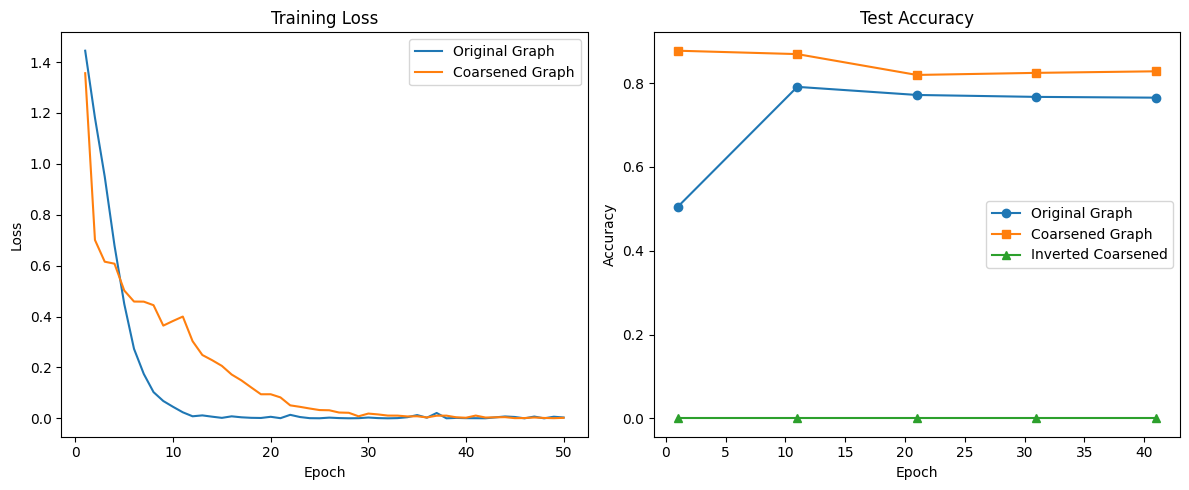

Final Performance Comparison:
Original Graph Accuracy: 0.7654
Coarsened Graph Accuracy: 0.8284
Inverted Coarsened Accuracy: 0.0000


In [27]:
# Import necessary libraries (if not already imported)
import torch
import torch.nn.functional as F
import numpy as np
from HGCN import ImprovedHeteroGNN


original_x_dict = original_data.x_dict
coarsened_x_dict = coarsened_data.x_dict
original_x_dict.update({"conference": torch.zeros((original_data["conference"]["num_nodes"], 1))})# = 0  #= 0#
#coarsened_x_dict.update({"conference": torch.zeros((coarsened_data["conference"]["num_nodes"], 1))})# = 0  #= 0#

num_classes = len(original_data["author"].y.unique())

# Your existing model definition
model_original = ImprovedHeteroGNN(metadata=original_data.metadata(), x_dict= original_x_dict ,num_classes= num_classes,hidden_channels=64)
model_coarsened = ImprovedHeteroGNN(metadata=coarsened_data.metadata(), x_dict= coarsened_x_dict,num_classes= num_classes, hidden_channels=64)

# Optimizers
optimizer_original = torch.optim.Adam(model_original.parameters(), lr=0.01, weight_decay=5e-4)
optimizer_coarsened = torch.optim.Adam(model_coarsened.parameters(), lr=0.01, weight_decay=5e-4)

def remap_edge_indices(edge_index_dict, node_mapping):
    """
    Remaps edge indices according to the new node IDs in the coarsened graph
    
    Args:
        edge_index_dict: Dictionary of edge indices for each relation type
        node_mapping: Dictionary mapping original node IDs to coarsened node IDs
        
    Returns:
        Remapped edge index dictionary
    """
    remapped_edge_index_dict = {}
    for edge_type, edge_index in edge_index_dict.items():
        src_type, rel_type, dst_type = edge_type
        
        # Remap source and destination node IDs
        src_mapping = node_mapping.get(src_type, {})
        dst_mapping = node_mapping.get(dst_type, {})
        
        # Create new edge index tensor
        new_edge_index = torch.zeros_like(edge_index)
        for i in range(edge_index.size(1)):
            src_id = edge_index[0, i].item()
            dst_id = edge_index[1, i].item()
            
            # Use mapped IDs
            new_edge_index[0, i] = src_mapping.get(src_id, src_id)
            new_edge_index[1, i] = dst_mapping.get(dst_id, dst_id)
        
        remapped_edge_index_dict[edge_type] = new_edge_index
    
    return remapped_edge_index_dict


# Function to apply inversion mapping from coarsened to original
def apply_inversion_mapping(coarsened_pred, inversion_map, original_labels):
    """
    Maps predictions from coarsened graph back to original graph nodes
    
    Args:
        coarsened_pred: Predictions on coarsened graph
        inversion_map: Mapping from coarsened nodes to original nodes
        original_labels: Ground truth labels of original graph
        
    Returns:
        mapped_accuracy: Accuracy after applying inversion mapping
    """
    correct_count = 0
    total_count = 0
    
    for coarse_node, orig_nodes in inversion_map.items():
        coarse_pred = coarsened_pred[coarse_node].item()
        
        for orig_node in orig_nodes:
            orig_label = original_labels[orig_node].item()
            
            # Apply the evaluation logic as described
            # If original_node_label = 0 and coarsened_node_label = 1 and predicted_coarsened_node = 1,
            # then it should return false (incorrect prediction)
            if (orig_label == 0 and coarse_pred == 1):
                correct = False
            else:
                correct = (coarse_pred == orig_label)
                
            if correct:
                correct_count += 1
            total_count += 1
    
    return correct_count / total_count if total_count > 0 else 0

# Training function for original graph
def train_original():
    model_original.train()
    optimizer_original.zero_grad()
    
    out = model_original(original_x_dict, original_data.edge_index_dict)
    loss = F.nll_loss(
        out['author'][original_data['author'].train_mask], 
        original_data['author'].y[original_data['author'].train_mask]
    )
    loss.backward()
    optimizer_original.step()
    return loss.item()

# Training function for coarsened graph
def train_coarsened():
    model_coarsened.train()
    optimizer_coarsened.zero_grad()
    out = model_coarsened(coarsened_x_dict, coarsened_data.edge_index_dict)
    loss = F.nll_loss(
        out['author'][coarsened_data['author'].train_mask], 
        coarsened_data['author'].y[coarsened_data['author'].train_mask]
    )
    loss.backward()
    optimizer_coarsened.step()
    return loss.item()

# Evaluation function for original graph
def test_original():
    model_original.eval()
    with torch.no_grad():
        out = model_original(original_x_dict, original_data.edge_index_dict)
        pred = out["author"].argmax(dim=1)
        
        # Calculate accuracy on test set
        correct = pred[original_data['author'].test_mask] == original_data['author'].y[original_data['author'].test_mask]
        acc = int(correct.sum()) / int(original_data['author'].test_mask.sum())
        return acc

# Evaluation function for coarsened graph
def test_coarsened():
    model_coarsened.eval()
    with torch.no_grad():
        out = model_coarsened(coarsened_x_dict, coarsened_data.edge_index_dict)
        pred = out["author"].argmax(dim=1)
        
        # Calculate accuracy on test set
        coarsened_acc = int(
            (pred[coarsened_data['author'].test_mask] == 
             coarsened_data['author'].y[coarsened_data['author'].test_mask]).sum()
        ) / int(coarsened_data['author'].test_mask.sum())
        
        # Apply inversion mapping to evaluate how coarsened predictions map to original graph
        inverted_acc  = 0#= apply_inversion_mapping(
            #pred,
            #inverse_mapping,
            #original_data['author'].y
        #)
        
        return coarsened_acc, inverted_acc

# Training for 50 epochs and comparing both models
results = {
    "epoch": [],
    "original_loss": [],
    "coarsened_loss": [],
    "original_acc": [],
    "coarsened_acc": [],
    "inverted_acc": []
}

for epoch in range(50):
    # Train both models
    original_loss = train_original()
    coarsened_loss = train_coarsened()
    
    # Store results
    results["epoch"].append(epoch+1)
    results["original_loss"].append(original_loss)
    results["coarsened_loss"].append(coarsened_loss)
    
    # Evaluate every 10 epochs
    if epoch % 10 == 0:
        original_acc = test_original()
        coarsened_acc, inverted_acc = test_coarsened()
        
        results["original_acc"].append(original_acc)
        results["coarsened_acc"].append(coarsened_acc)
        results["inverted_acc"].append(inverted_acc)
        
        print(f'Epoch {epoch+1}:')
    
    
        print(f'  Original Graph - Loss: {original_loss:.4f}, Accuracy: {original_acc:.4f}')
        print(f'  Coarsened Graph - Loss: {coarsened_loss:.4f}, Accuracy: {coarsened_acc:.4f}')
        print(f'  Inverted Coarsened - Accuracy: {inverted_acc:.4f}')
        print()

# Visualization of results
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results["epoch"], results["original_loss"], label="Original Graph")
plt.plot(results["epoch"], results["coarsened_loss"], label="Coarsened Graph")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
x = [results["epoch"][i] for i in range(0, 50, 10)]
plt.plot(x, results["original_acc"], 'o-', label="Original Graph")
plt.plot(x, results["coarsened_acc"], 's-', label="Coarsened Graph")
plt.plot(x, results["inverted_acc"], '^-', label="Inverted Coarsened")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Final comparison
print("Final Performance Comparison:")
print(f"Original Graph Accuracy: {results['original_acc'][-1]:.4f}")
print(f"Coarsened Graph Accuracy: {results['coarsened_acc'][-1]:.4f}")
print(f"Inverted Coarsened Accuracy: {results['inverted_acc'][-1]:.4f}")

# Calculate speedup from using coarsened graph
# (You would need to time the training for a proper comparison)